In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
import os
from tensorflow.keras.utils import to_categorical

# Drive mounting and data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# !ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/CIS\ 602 /project
# !ls /project/UTKFace

!ln -s /content/gdrive/My\ Drive/Computer_Vision/CIS\ 602/UTKFace

ln: failed to create symbolic link './UTKFace': File exists


In [ ]:
!ls UTKFace/

part1  part1.zip  part2  part2.zip  part3  part3.zip  part4  part4.zip


In [ ]:
# !unzip "/project/UTKFace/part1.zip" -d "/content"
# !unzip "/project/UTKFace/part2.zip" -d "/content"
# !unzip "/project/UTKFace/part3.zip" -d "/content"
# !unzip "/project/UTKFace/part4.zip" -d "/content"

!unzip "UTKFace/part1.zip" -d "/content"
!unzip "UTKFace/part2.zip" -d "/content"
!unzip "UTKFace/part3.zip" -d "/content"
!unzip "UTKFace/part4.zip" -d "/content"

Archive:  UTKFace/part1.zip
replace /content/part1/10_0_0_20161220222308131.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  UTKFace/part2.zip
replace /content/part2/29_0_4_20170104200952009.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  UTKFace/part3.zip
replace /content/part3/20_1_2_20170116163800040.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  UTKFace/part4.zip
replace /content/part4/100_0_0_20170112213500903.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Method defination for data transformation, splitting and model training.

In [ ]:
def data_load_and_model_fitting(model, data_paths, label):
  data = []
  labels = []
  print('Loading Images...')
  i = 0
  # loop over the image paths
  for data_path in data_paths:
    for images in os.listdir(data_path):
      i+=1
      image_name = os.path.split(images)[1]
      image_name = os.path.splitext(image_name)[0]
      image_parts = image_name.split('_')
      if len(image_parts) == 4:
        image = load_img(data_path+images, target_size=(198, 198))
        image = img_to_array(image)
        image = preprocess_input(image)
        # update the data and labels lists, respectively
        data.append(image)
        if 'g' == label:
          labels.append(image_parts[1])
        elif 'e' == label:
          labels.append(image_parts[2])
        else:
          raise Exception('None recognizable label')


  print('Loaded total',i,'images.')

  # Data conversion and splitting
  data = np.array(data, dtype="float32")
  labels = np.array(labels)
  if 'g' == label:
    labels = LabelBinarizer().fit_transform(labels)
    labels = to_categorical(labels)
  elif 'e' == label:
    labels = LabelBinarizer().fit_transform(labels)
  else:
    raise Exception('None recognizable label')

  (trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)
  
  aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")
  print("[INFO] training Model...")
  
  history = model.fit(
      aug.flow(trainX, trainY, batch_size=20),
      validation_data=(testX, testY),
      epochs=20, callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1)])
  
  # Plot the accuracy and los improvement in graph to show how well model is getting trained on.
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.plot(history.history['acc'], label='Training Accuracy')
  plt.plot(history.history['val_acc'], label='Validation Accuracy')
  plt.ylabel('Value')
  plt.xlabel('No. epoch')
  plt.legend(loc="upper right")
  plt.show()
  return model

# Base Model for Ethnicity and Gender

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(198, 198, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)

# for layer in baseModel.layers:
#     layer.trainable = False

In [ ]:
INIT_LR = 1e-4
EPOCHS = 20

# Optimizer
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

# Gender Model Compiling

## Part 1 and 2 training

In [ ]:
gender_model = Dense(2, activation="softmax")(headModel)

gender_model = Model(inputs=baseModel.input, outputs= gender_model)

In [ ]:
print("[INFO] compiling model...")
loss="binary_crossentropy"
gender_model.compile(loss=loss, optimizer=opt,
    metrics=["acc"])

[INFO] compiling model...


[INFO] training Gender Model for part 1 and 2...
Loading Images...
Loaded total 9960 images.
[INFO] training Model...
Epoch 1/20
399/399 [==============================] - 123s 214ms/step - loss: 0.6076 - acc: 0.6730 - val_loss: 0.3984 - val_acc: 0.8017
Epoch 2/20
399/399 [==============================] - 82s 204ms/step - loss: 0.3999 - acc: 0.8097 - val_loss: 0.3188 - val_acc: 0.8529
Epoch 3/20
399/399 [==============================] - 82s 204ms/step - loss: 0.3492 - acc: 0.8438 - val_loss: 0.2948 - val_acc: 0.8695
Epoch 4/20
399/399 [==============================] - 82s 205ms/step - loss: 0.3350 - acc: 0.8458 - val_loss: 0.3006 - val_acc: 0.8624
Epoch 5/20
399/399 [==============================] - 81s 204ms/step - loss: 0.2901 - acc: 0.8770 - val_loss: 0.2930 - val_acc: 0.8730
Epoch 6/20
399/399 [==============================] - 81s 203ms/step - loss: 0.2852 - acc: 0.8702 - val_loss: 0.3705 - val_acc: 0.8604
Epoch 7/20
399/399 [==============================] - 81s 203ms/step - 

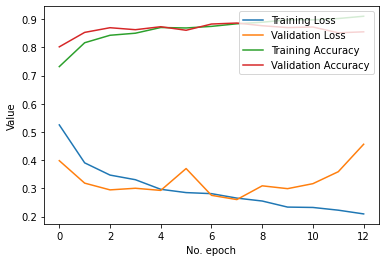

In [ ]:
print("[INFO] training Gender Model for part 1 and 2...")
gender_model = data_load_and_model_fitting(gender_model,{'/content/part1/','/content/part2/'},'g')

In [ ]:
gender_model.save("gender_Model12.h5")

## Part 4 training

In [ ]:
gender_model = load_model("gender_Model12.h5")

[INFO] training Gender Model for part 4/3...
Loading Images...
Loaded total 6920 images.
[INFO] training Model...
Epoch 1/20
277/277 [==============================] - 92s 212ms/step - loss: 0.2115 - acc: 0.9180 - val_loss: 0.3153 - val_acc: 0.9184
Epoch 2/20
277/277 [==============================] - 56s 204ms/step - loss: 0.1460 - acc: 0.9463 - val_loss: 0.2586 - val_acc: 0.9321
Epoch 3/20
277/277 [==============================] - 56s 203ms/step - loss: 0.1185 - acc: 0.9523 - val_loss: 0.2642 - val_acc: 0.9321
Epoch 4/20
277/277 [==============================] - 57s 206ms/step - loss: 0.1062 - acc: 0.9648 - val_loss: 0.2038 - val_acc: 0.9465
Epoch 5/20
277/277 [==============================] - 57s 205ms/step - loss: 0.0956 - acc: 0.9664 - val_loss: 0.2400 - val_acc: 0.9357
Epoch 6/20
277/277 [==============================] - 57s 206ms/step - loss: 0.0852 - acc: 0.9707 - val_loss: 0.1697 - val_acc: 0.9465
Epoch 7/20
277/277 [==============================] - 57s 206ms/step - loss:

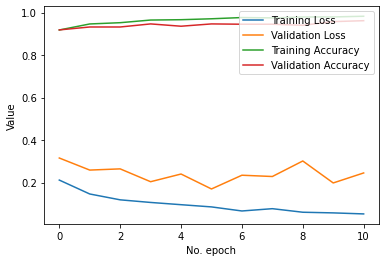

In [ ]:
print("[INFO] training Gender Model for part 4/3...")
gender_model = data_load_and_model_fitting(gender_model,{'/content/part4/'},'g')

In [ ]:
gender_model.save("gender_Model124.h5")

## Part 3 training

In [ ]:
gender_model = load_model("gender_Model124.h5")

[INFO] training Gender Model for part 3...
Loading Images...
Loaded total 6828 images.
[INFO] training Model...
Epoch 1/20
274/274 [==============================] - 64s 214ms/step - loss: 0.1827 - acc: 0.9427 - val_loss: 0.2250 - val_acc: 0.9327
Epoch 2/20
274/274 [==============================] - 56s 205ms/step - loss: 0.1467 - acc: 0.9524 - val_loss: 0.1924 - val_acc: 0.9524
Epoch 3/20
274/274 [==============================] - 56s 205ms/step - loss: 0.1307 - acc: 0.9608 - val_loss: 0.2229 - val_acc: 0.9392
Epoch 4/20
274/274 [==============================] - 56s 205ms/step - loss: 0.1111 - acc: 0.9678 - val_loss: 0.1576 - val_acc: 0.9553
Epoch 5/20
274/274 [==============================] - 56s 204ms/step - loss: 0.1078 - acc: 0.9669 - val_loss: 0.1467 - val_acc: 0.9561
Epoch 6/20
274/274 [==============================] - 56s 205ms/step - loss: 0.0954 - acc: 0.9685 - val_loss: 0.1577 - val_acc: 0.9597
Epoch 7/20
274/274 [==============================] - 56s 204ms/step - loss: 0

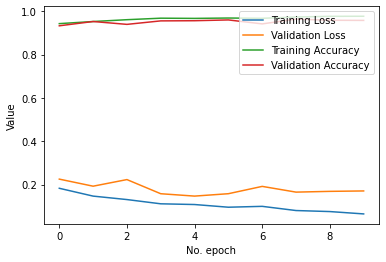

In [ ]:
print("[INFO] training Gender Model for part 3...")
gender_model = data_load_and_model_fitting(gender_model,{'/content/part3/'},'g')

In [ ]:
gender_model.save("gender_Model_final.h5")